## Computer Vision: Cálculo de NDVI

Referencia: https://medium.com/@lopezyse/computer-vision-analyzing-satellite-images-using-python-f3792a4bc140

Imagenes: https://drive.google.com/drive/folders/1FId4HU9LXhMj8yyjKwrRfW6r39s75eAa?usp=sharing

In [1]:
import os
os.getcwd()

'c:\\Users\\CynYDie\\Desktop\\UTN_Haedo\\Clases\\Clase14_CV'

In [2]:
# Imports
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

In [3]:
# Load and prepare data
b4 = rasterio.open('datasets/LC09_L1TP_227082_20231015_20231015_02_T1_B4.TIF').read(1)
b5 = rasterio.open('datasets/LC09_L1TP_227082_20231015_20231015_02_T1_B5.TIF').read(1)
red = b4.astype('float64')
nir = b5.astype('float64')

In [4]:
# Define NDVI calculation function
def calculate_ndvi(nir_band, red_band):
    """Calculate NDVI from NIR and Red bands"""
    ndvi = (nir_band - red_band) / (nir_band + red_band + 1e-10)
    ndvi = np.clip(ndvi, -1, 1)
    return ndvi

# Calculate NDVI
ndvi_result = calculate_ndvi(nir, red)

In [5]:
# Save NDVI as GeoTIFF
with rasterio.open('datasets/LC09_L1TP_227082_20231015_20231015_02_T1_B4.TIF') as src:
    profile = src.profile
    profile.update(
        dtype=rasterio.float32,
        count=1,
        compress='lzw',
        nodata=None
    )
    with rasterio.open('datasets/ndvi_result.tif', 'w', **profile) as dst:
        dst.write(ndvi_result.astype(rasterio.float32), 1)

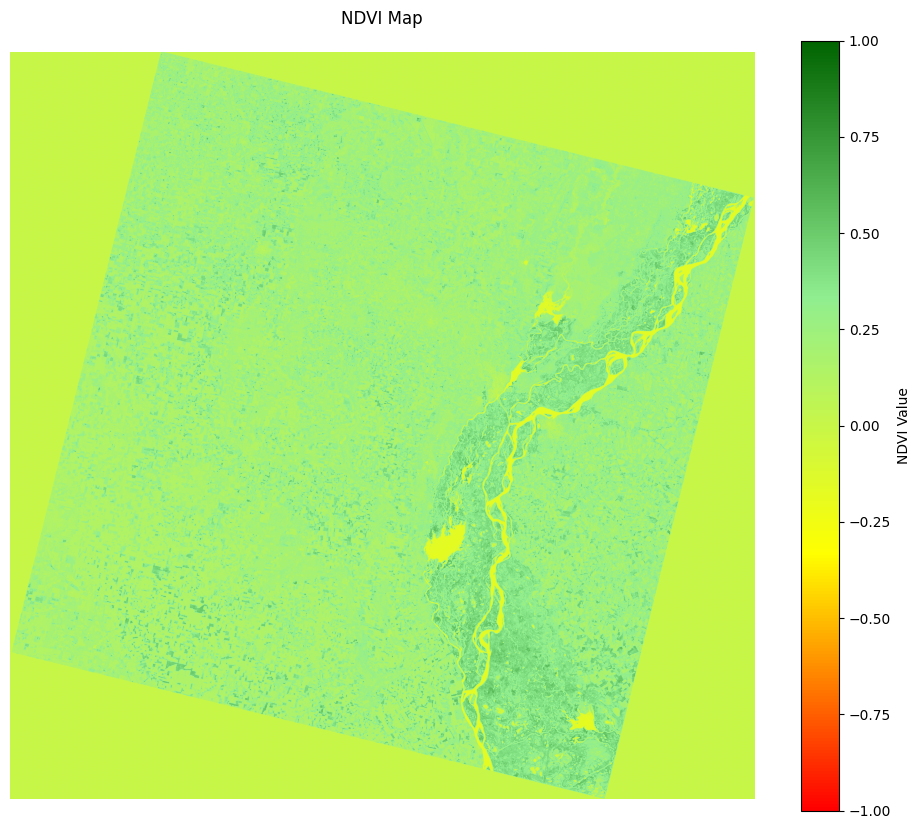

In [6]:
# Create and display NDVI Map
plt.figure(figsize=(12, 10))
colors = ['red', 'yellow', 'lightgreen', 'darkgreen']
ndvi_cmap = LinearSegmentedColormap.from_list("custom", colors, N=256)

im = plt.imshow(ndvi_result, cmap=ndvi_cmap, vmin=-1, vmax=1)
plt.colorbar(im, label='NDVI Value')
plt.title('NDVI Map', pad=20)
plt.axis('off')
plt.show()

In [7]:
# Calculate basic statistics
valid_ndvi = ndvi_result[~np.isnan(ndvi_result)]
stats = {
    'Mean': np.mean(valid_ndvi),
    'Median': np.median(valid_ndvi),
    'Std Dev': np.std(valid_ndvi),
    'Min': np.min(valid_ndvi),
    'Max': np.max(valid_ndvi)
}

for stat, value in stats.items():
    print(f"{stat}: {value:.3f}")

Mean: 0.163
Median: 0.162
Std Dev: 0.147
Min: -0.394
Max: 1.000


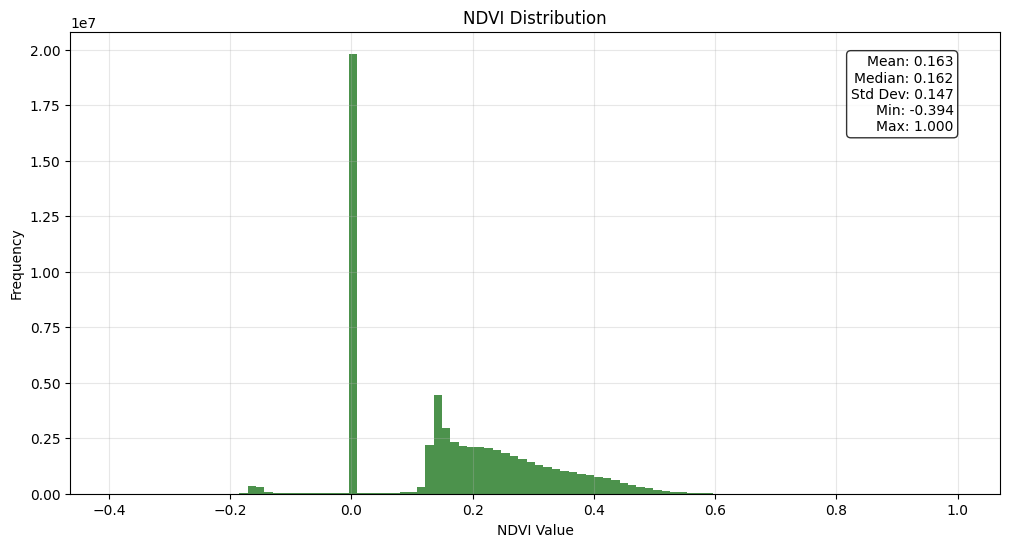

In [8]:
# Create and display Histogram
plt.figure(figsize=(12, 6))
plt.hist(valid_ndvi.flatten(), bins=100, color='darkgreen', alpha=0.7)
plt.title('NDVI Distribution')
plt.xlabel('NDVI Value')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# Add statistics to plot
stats_text = '\n'.join([f'{k}: {v:.3f}' for k, v in stats.items()])
plt.text(0.95, 0.95, stats_text,
         transform=plt.gca().transAxes,
         verticalalignment='top',
         horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.show()

NDVI Threshold Areas with Statistics

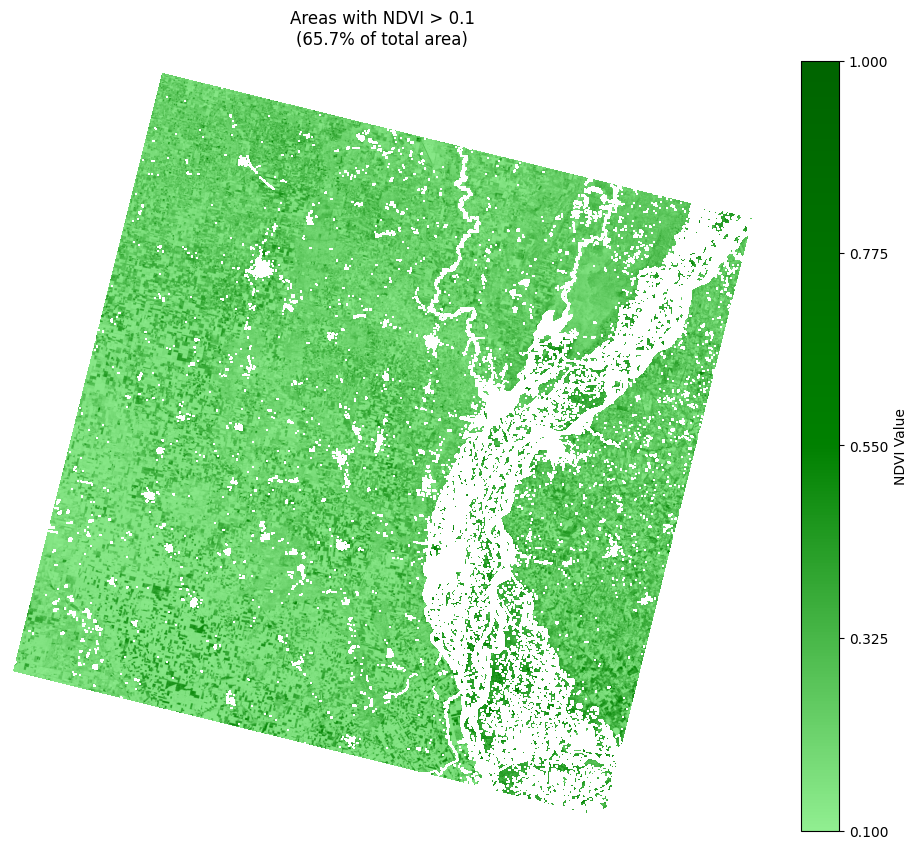


Statistics for NDVI > 0.1:
----------------------------------------
Total pixels:             61637801
Pixels above threshold:   40510265
Percentage above threshold: 65.7%
Mean NDVI:                0.251
Median NDVI:              0.231
Max NDVI:                 1.000
Min NDVI:                 0.100
Std Dev:                  0.100


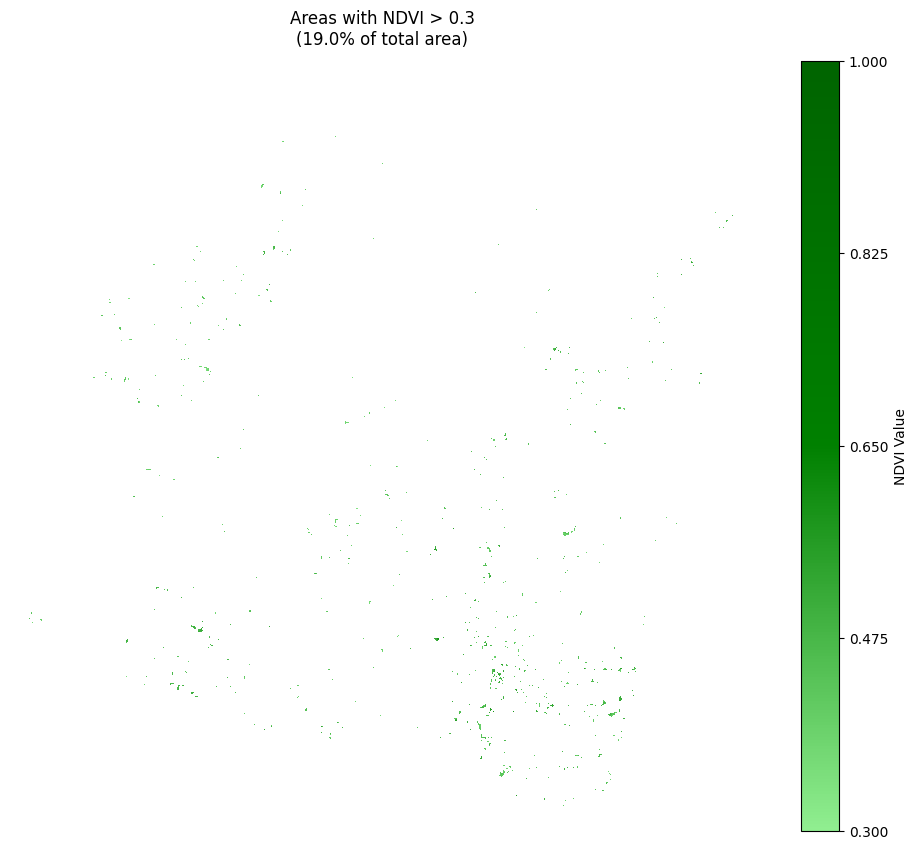


Statistics for NDVI > 0.3:
----------------------------------------
Total pixels:             61637801
Pixels above threshold:   11692884
Percentage above threshold: 19.0%
Mean NDVI:                0.383
Median NDVI:              0.372
Max NDVI:                 1.000
Min NDVI:                 0.300
Std Dev:                  0.060


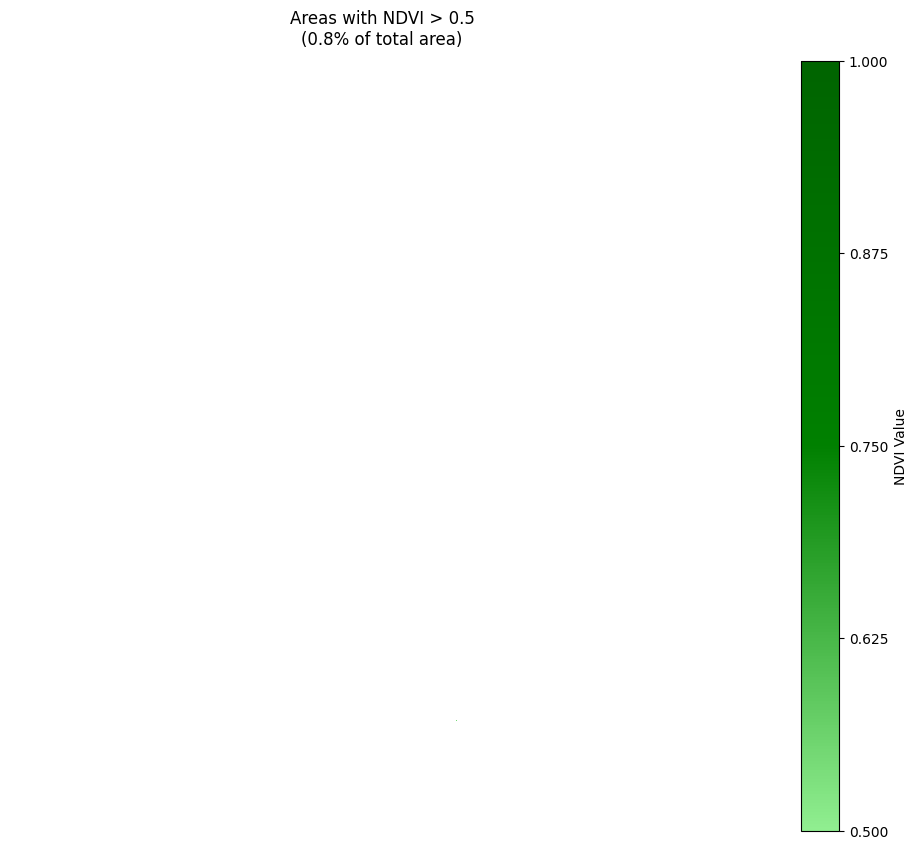


Statistics for NDVI > 0.5:
----------------------------------------
Total pixels:             61637801
Pixels above threshold:   521460
Percentage above threshold: 0.8%
Mean NDVI:                0.531
Median NDVI:              0.524
Max NDVI:                 1.000
Min NDVI:                 0.500
Std Dev:                  0.031

Comparative Summary of All Thresholds:
------------------------------------------------------------
                                 0.1       0.3       0.5
Total pixels                61637801  61637801  61637801
Pixels above threshold      40510265  11692884    521460
Percentage above threshold     65.7%     19.0%      0.8%
Mean NDVI                      0.251     0.383     0.531
Median NDVI                    0.231     0.372     0.524
Max NDVI                       1.000     1.000     1.000
Min NDVI                       0.100     0.300     0.500
Std Dev                        0.100     0.060     0.031


In [ ]:
# Create visualization and statistics for areas above threshold
def analyze_ndvi_threshold(ndvi_data, threshold):
    """
    Plot NDVI areas above threshold and display statistics
    
    Parameters:
    ndvi_data: numpy array of NDVI values
    threshold: NDVI value above which to show areas
    """
    plt.figure(figsize=(12, 10))
    
    # Create mask for values above threshold
    high_ndvi_mask = ndvi_data > threshold
    
    # Create masked array where values below threshold are transparent
    masked_ndvi = np.ma.masked_where(~high_ndvi_mask, ndvi_data)
    
    # Create colormap for high NDVI values
    colors_high = ['lightgreen', 'green', 'darkgreen']
    high_ndvi_cmap = LinearSegmentedColormap.from_list("custom_high", colors_high, N=256)
    
    # Plot with white background
    plt.imshow(np.zeros_like(ndvi_data), cmap='Greys', alpha=0.1)
    plt.imshow(masked_ndvi, cmap=high_ndvi_cmap, vmin=threshold, vmax=1)
    
    # Add colorbar
    cbar = plt.colorbar(label='NDVI Value')
    cbar.set_ticks(np.linspace(threshold, 1, 5))
    
    # Calculate statistics for areas above threshold
    high_ndvi_values = ndvi_data[high_ndvi_mask]
    total_pixels = ndvi_data.size
    pixels_above = high_ndvi_values.size
    percentage_above = (pixels_above / total_pixels) * 100
    
    stats = {
        'Total pixels': total_pixels,
        'Pixels above threshold': pixels_above,
        'Percentage above threshold': f"{percentage_above:.1f}%",
        'Mean NDVI': f"{np.mean(high_ndvi_values):.3f}",
        'Median NDVI': f"{np.median(high_ndvi_values):.3f}",
        'Max NDVI': f"{np.max(high_ndvi_values):.3f}",
        'Min NDVI': f"{np.min(high_ndvi_values):.3f}",
        'Std Dev': f"{np.std(high_ndvi_values):.3f}"
    }
    
    # Add title
    plt.title(f'Areas with NDVI > {threshold}\n'
              f'({percentage_above:.1f}% of total area)',
              pad=20)
    
    plt.axis('off')
    plt.show()
    
    # Print statistics
    print(f"\nStatistics for NDVI > {threshold}:")
    print("-" * 40)
    for key, value in stats.items():
        print(f"{key + ':':25} {value}")
    
    return high_ndvi_mask, stats

# Create visualizations and get statistics for different thresholds
thresholds = [0.1, 0.3, 0.5]

# Dictionary to store statistics for all thresholds
all_stats = {}

for threshold in thresholds:
    mask, stats = analyze_ndvi_threshold(ndvi_result, threshold)
    all_stats[threshold] = stats

# Create comparative summary table
import pandas as pd

# Convert statistics to DataFrame for easy comparison
df_stats = pd.DataFrame(all_stats).round(3)
print("\nComparative Summary of All Thresholds:")
print("-" * 60)
print(df_stats)